# Does working for a Sillicon Valley company matter?

Introduction goes here

In [4]:
# imports
import pandas as pd
import numpy
from scipy import stats

In [5]:
# grab all the data we need from the db
from sqlalchemy import create_engine
engine = create_engine('sqlite:////Users/rachel/projects/eng_survey_raw/results.db')
with engine.connect() as conn, conn.begin():
    eng_traits_data = pd.read_sql_table('q1_competent_software_engineer_traits', conn)
    setup_questions_data = pd.read_sql_table('q3q6_setup_questions', conn)
    current_company_data = pd.read_sql_table('q12q15_current_company', conn)


In [6]:
# plots n graphs setup shenanigans
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 20)
plt.rcParams['font.family'] = 'sans-serif'

In [7]:
# constants
IN_SILICON_VALLEY = 1 # answer to "Is your company in Silicon Valley?
OUTSIDE_SV = 0 # answer to "Is your company in Silicon Valley?

# Do engineers with CS degrees value different skills than engineers without CS degrees? 

An interesting way to slice this data is by people who have CS degrees vs. people who do not. 


In [8]:
# this gets a list of engineering traits so we can pivot on them later
excluded_trait_columns = ('id', 'response_id', 'something_else_writein1', 'something_else_writein2')
eng_traits = [trait for trait in list(eng_traits_data.columns.values) if trait not in excluded_trait_columns]

In [9]:
# Smoosh the right bits of data together. In this case, we want 1) eng traits 
# 2) split out by CS degree 3) by people who identify themselves as engineers 

current_company_data = pd.merge(eng_traits_data, 
                           current_company_data[["response_id", "current_company_in_silicon_valley"]], 
                           on="response_id", 
                           how="inner",
                           sort=False)
only_software_engineers = setup_questions_data.query("are_you_a_software_engineer == True")

current_company_engineers_only_data = pd.merge(current_company_data, only_software_engineers[["response_id"]], on="response_id", how="inner", sort=False)

In [13]:
traits_data = pd.pivot_table(current_company_engineers_only_data, index=["current_company_in_silicon_valley"], values=eng_traits)

# How many traits did people pick? 

In [14]:
current_company_engineers_only_data['number_selected'] = current_company_engineers_only_data[eng_traits].sum(axis=1, numeric_only=True)

In [15]:
number_selected = current_company_engineers_only_data['number_selected']

selected_std_dev = numpy.std(number_selected)
selected_mean = numpy.mean(number_selected)
selected_std_dev, selected_mean

(6.430936686434689, 20.727134146341463)

In [17]:
traits_count_by_location = pd.pivot_table(current_company_engineers_only_data, 
                                        index=["current_company_in_silicon_valley"], 
                                        values=['number_selected'],
                                        aggfunc=[numpy.mean, numpy.std])
traits_count_by_location

,mean,std
,number_selected,number_selected
current_company_in_silicon_valley,,
False,20.741273,6.204572
True,20.686391,7.079640


## What does each group value the highest?

If you sort by the top 10 traits valued by both groups, 9 out of 10 are the same, with the top 5 being exactly the same and in the same order. 

Interestingly, there's only one true technical skill on both lists, and it's the 1 out of 10 that disagreed: engineers with CS degrees value rated data structures higher and engineers without rated knowing language features higher.

All the other skills are primarily social, e.g. teamwork, empathy, curiousity, humility, or technically social:  being fluent in both reading other people's code and writing for them as well as making tradeoffs.

In [18]:
traits_data.stack()[IN_SILICON_VALLEY].sort_values(ascending=False)[:10]

logically_work_through_problem     0.946746
write_code_for_others              0.928994
reason_about_other_peoples_code    0.928994
teamwork                           0.899408
can_admit_mistakes                 0.857988
shipping_code                      0.852071
can_make_tradeoffs                 0.822485
curiousity                         0.810651
data_structures                    0.769231
language_features_knowledge        0.745562
dtype: float64

In [19]:
traits_data.stack()[OUTSIDE_SV].sort_values(ascending=False)[:10]

logically_work_through_problem     0.940452
write_code_for_others              0.934292
reason_about_other_peoples_code    0.897331
can_admit_mistakes                 0.878850
teamwork                           0.839836
empathy                            0.815195
curiousity                         0.809035
shipping_code                      0.786448
can_make_tradeoffs                 0.784394
code_structure_skills              0.726899
dtype: float64

## What do people with CS and non-CS degrees value differently?

The next interesting question is: are there traits each group values more than the other? 

TODO: should we change this to be by raw numbers instead of comparing percentages? idk

In [30]:
traits_by_location = traits_data.transpose()
traits_by_location['Difference'] = (traits_by_location[IN_SILICON_VALLEY] - traits_by_location[OUTSIDE_SV])
traits_by_location.applymap(lambda x: '%.1f%%' % (x * 100))

current_company_in_silicon_valley,False,True,Difference
adapability,61.8%,58.6%,-3.2%
advanced_algorithms,16.4%,10.1%,-6.4%
can_act_in_crisis,37.4%,34.3%,-3.1%
can_admit_mistakes,87.9%,85.8%,-2.1%
can_handle_disruptions_or_interruptions,28.3%,25.4%,-2.9%
can_learn_quickly,66.3%,63.9%,-2.4%
can_make_tradeoffs,78.4%,82.2%,3.8%
code_structure_skills,72.7%,65.7%,-7.0%
concurrency,56.1%,57.4%,1.3%
curiousity,80.9%,81.1%,0.2%


In [27]:
traits_difference = traits_by_location.apply(lambda row: (row[IN_SILICON_VALLEY] - row[OUTSIDE_SV]) * 100,axis=1)


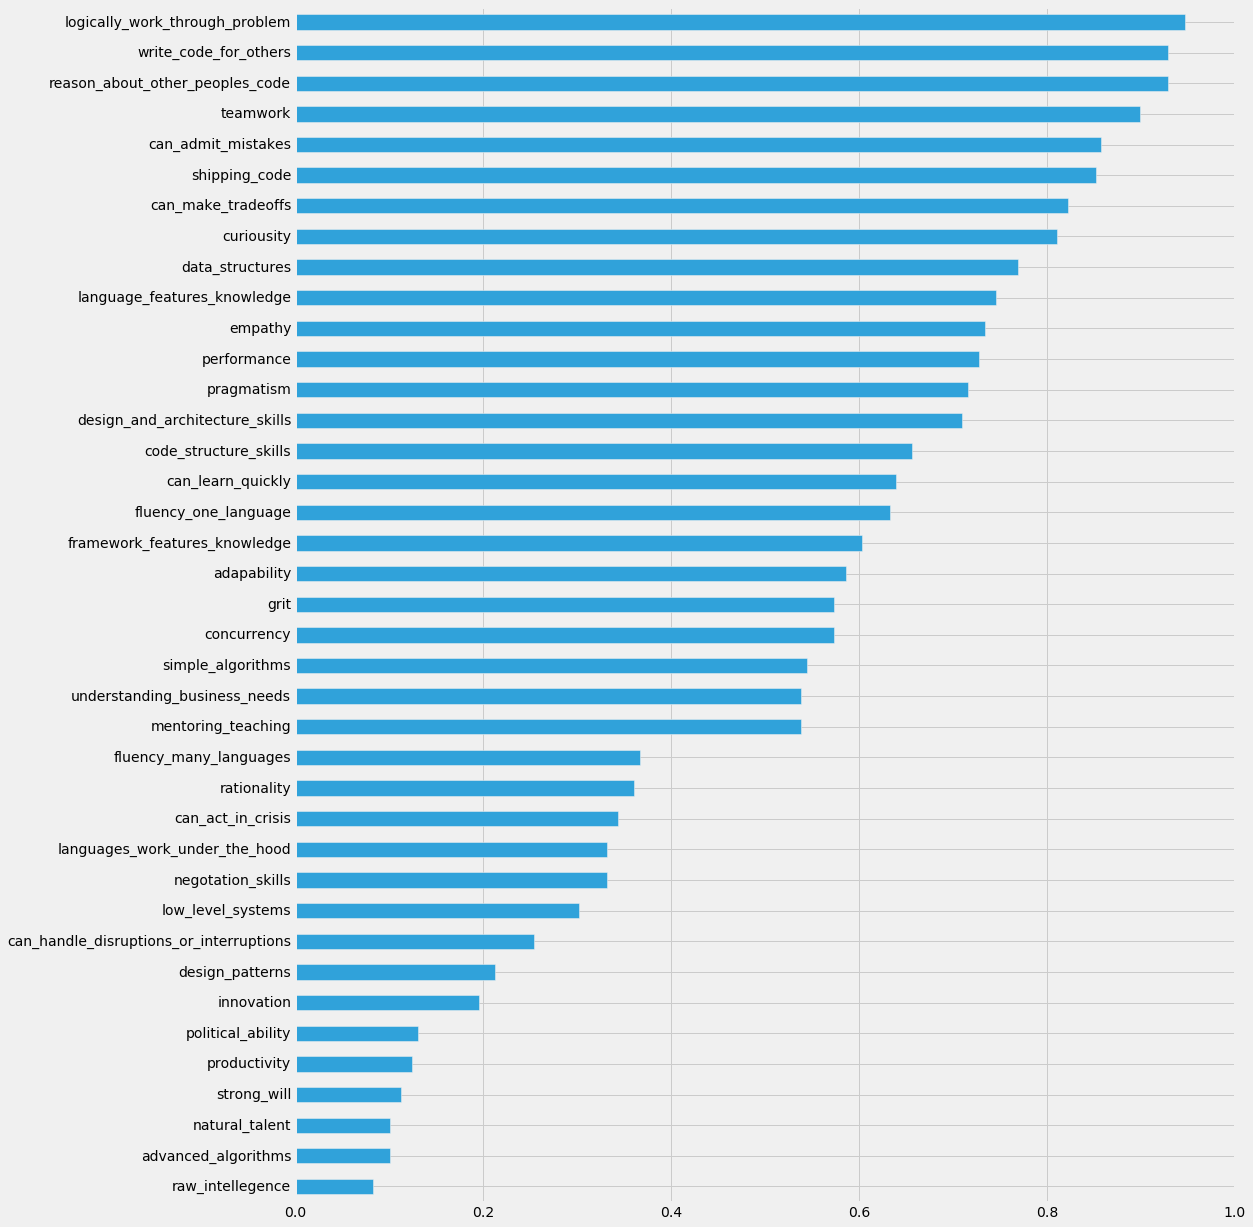

In [24]:
trait_plot2 = traits_data.stack()[IN_SILICON_VALLEY].sort_values(ascending=True).plot(kind='barh')

plt.show()

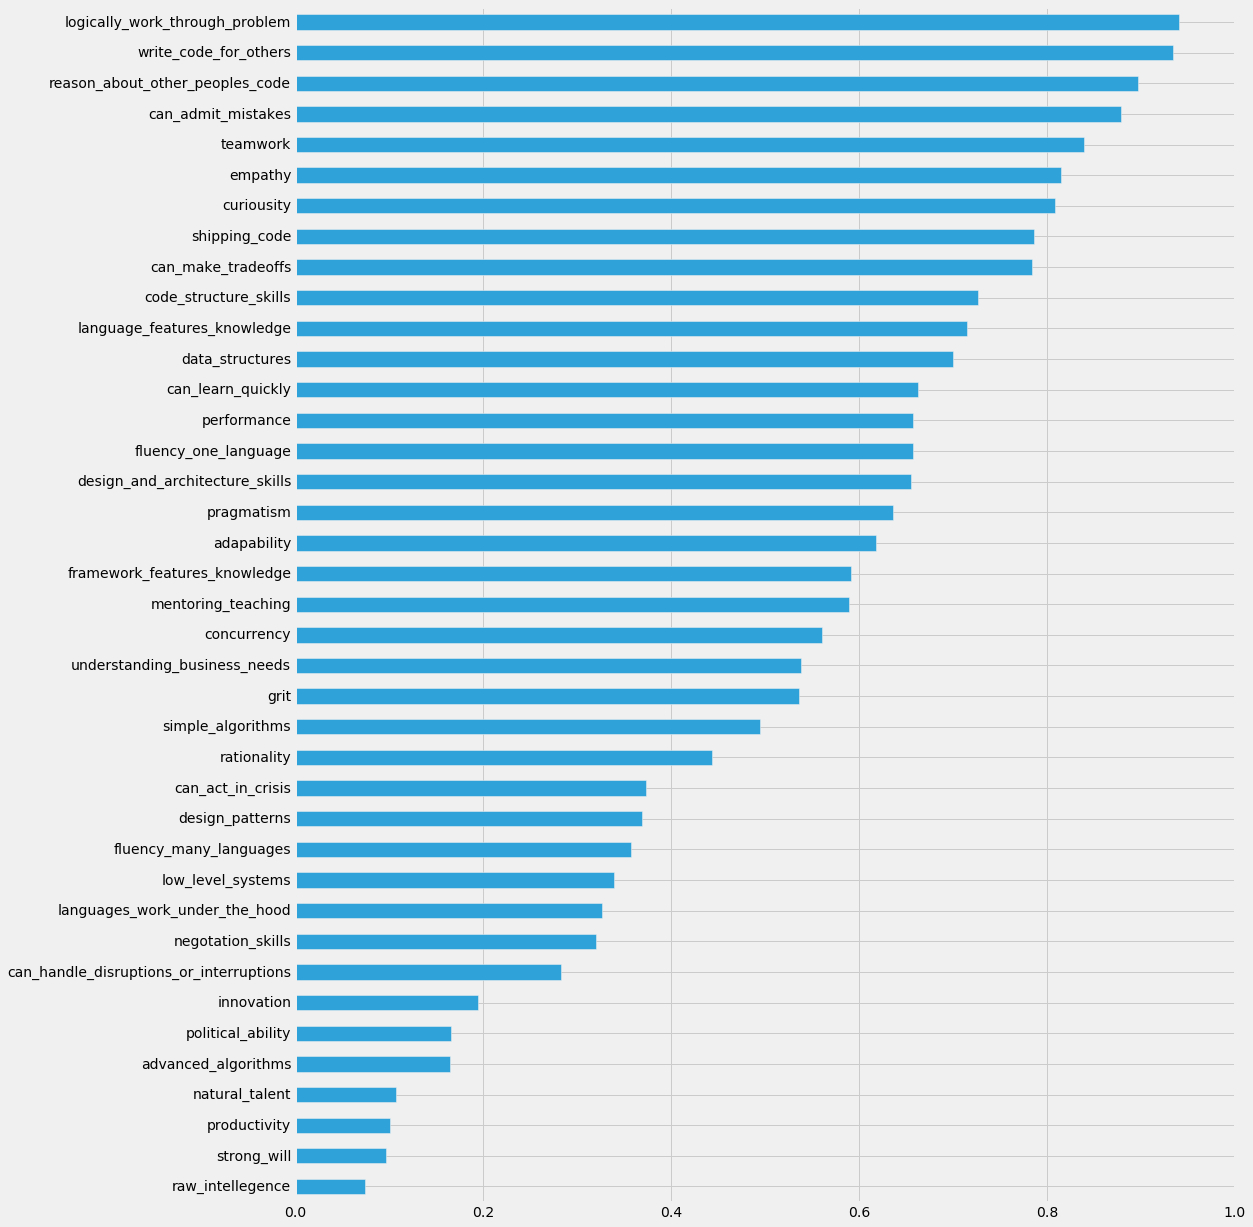

In [25]:
trait_plot3 = traits_data.stack()[OUTSIDE_SV].sort_values(ascending=True).plot(kind='barh')
plt.show()

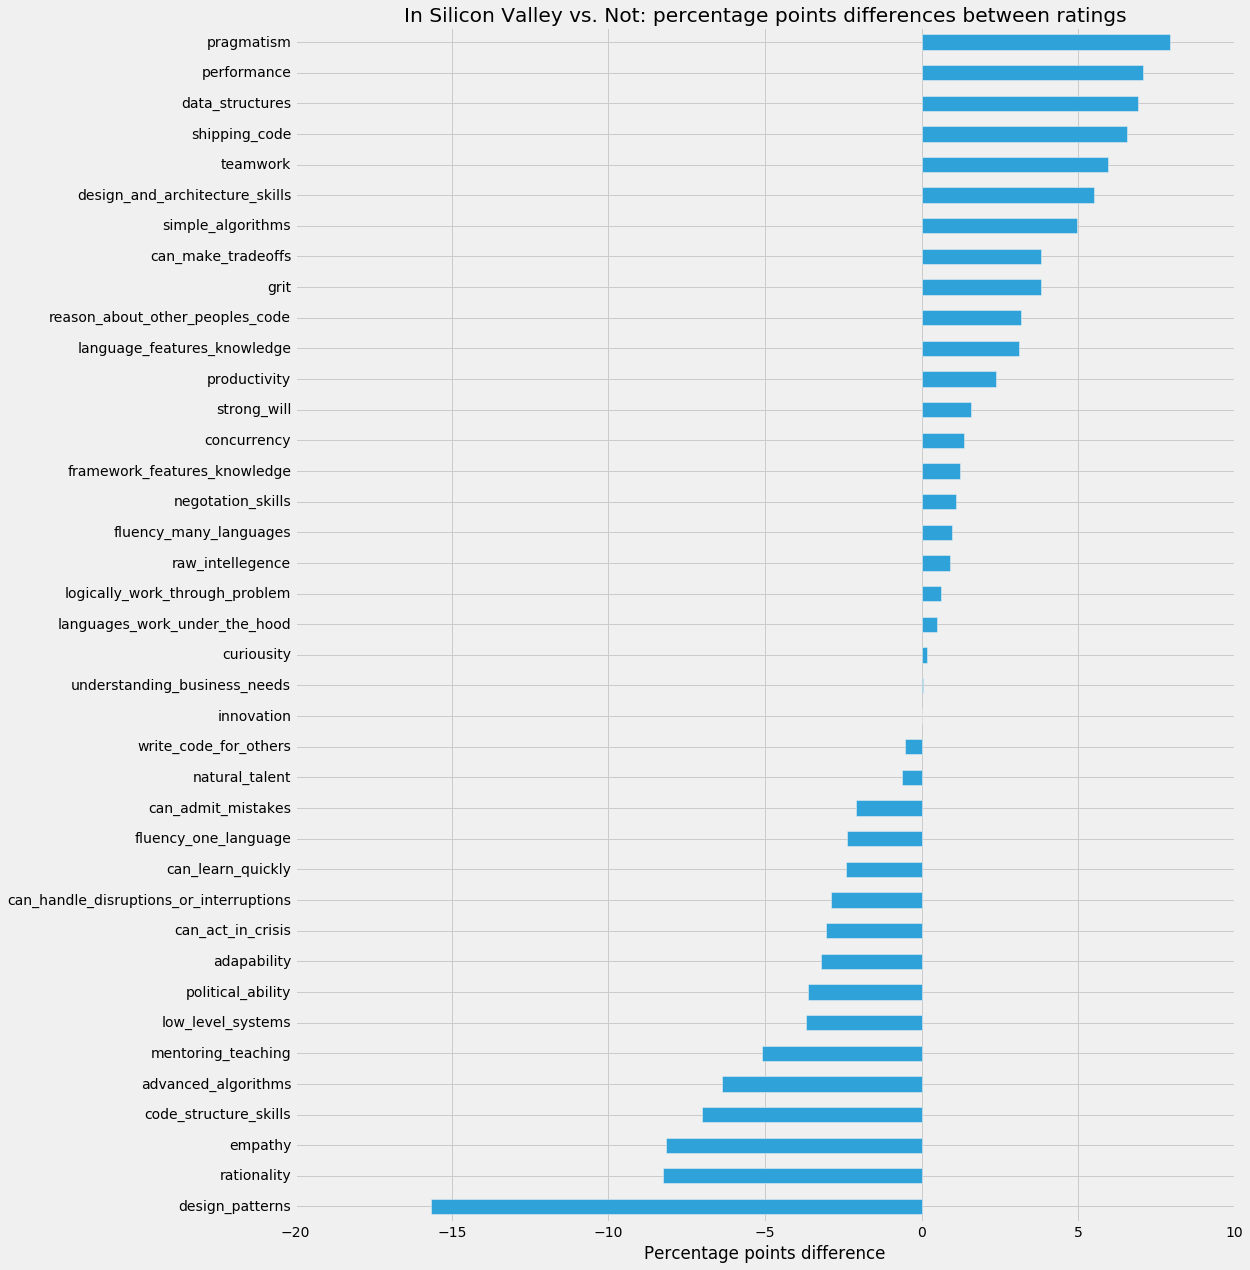

In [31]:
trait_plot = traits_difference.sort_values(ascending=True).plot(kind='barh')
trait_plot.set_title('In Silicon Valley vs. Not: percentage points differences between ratings')
trait_plot.set_xlabel('Percentage points difference')

plt.show()

# Statistical significance

trying out t-test here

In [32]:
in_silicon_valley_group = current_company_engineers_only_data[current_company_engineers_only_data['current_company_in_silicon_valley'] == True]
outside_silicon_valley_group = current_company_engineers_only_data[current_company_engineers_only_data['current_company_in_silicon_valley'] == False]

ttest_significance = []
for trait in eng_traits:
    result = stats.ttest_ind(in_silicon_valley_group[trait], outside_silicon_valley_group[trait])
    ttest_significance.append({'trait': trait, 'ttest_statistic': result.statistic, 'pvalue': result.pvalue})
    
ttest = pd.DataFrame(ttest_significance, columns=['trait', 'pvalue', 'ttest_statistic'])

The t-test is supposed to show how likely it is the two groups differ by chance, with the standard threshold being 5% (0.05). The correlation to this is 1 in 20 of these is statistically wrong.

In [33]:
ttest[ttest['pvalue'] <= 0.05].sort_values('pvalue')

,trait,pvalue,ttest_statistic
11,design_patterns,0.000180,-3.766813
22,empathy,0.023994,-2.262492
2,advanced_algorithms,0.044573,-2.012538
